# Dictionary Learning
Outdated work from an initial approach using dictionary learning instead of autoencoders to generate representations.

In [1]:
from dictlearn import DictionaryLearning
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from sklearn.linear_model import OrthogonalMatchingPursuit
from scipy.fftpack import dct

In [2]:
def filepath2vecs(filepath, chunk_size=16, quantize=16):
    """
    Loads the image and breaks it into (default) 16x16 chunks, returning a tensor with pixel values for each chunk.
    """
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    img = np.round(img * quantize) / quantize
    
    # Determine padding size
    height, width = img.shape[:2]
    pad_height = (chunk_size - height % chunk_size) % chunk_size
    pad_width = (chunk_size - width % chunk_size) % chunk_size
    
    # Pad image if necessary
    img = np.pad(img, ((0, pad_height), (0, pad_width)), mode='constant')
    
    # Reshape image into chunks
    chunks = [img[i:i+chunk_size, j:j+chunk_size] for i in range(0, img.shape[0], chunk_size) for j in range(0, img.shape[1], chunk_size)]
    
    # Convert each chunk into a row vector and stack them into a tensor
    chunk_tensors = [torch.from_numpy(chunk.flatten()) for chunk in chunks]
    image_tensor = torch.stack(chunk_tensors)
    
    return image_tensor

def show_vec(vec, size=(16, 16)):
    """
    Given a 1-dimensional greyscale rep of an image, show it
    """
    width, height = size
    img_2d = vec.reshape((height, width))
    plt.imshow(img_2d, cmap='gray', vmin=0.0, vmax=1.0)
    plt.axis('off')
    plt.show()

def folder_to_tensor(folder_path):
    """
    Loads all images from a folder as tensors and concatenates them into a tensor
    """
    image_tensors = []
    
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        if os.path.isfile(filepath):
            vecs = filepath2vecs(filepath)
            image_tensors.append(vecs)
    
    image_tensor = torch.cat(image_tensors)
    return image_tensor

def vec2rep(vec, dictionary, n_nonzero_coefs):
    """
    Given a dictionary of shape (num_components, num_features) get the representation as a vector
    of length (num_components)
    """
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs, tol=None)
    omp.fit(dictionary.T, vec)
    coefficients = torch.tensor(omp.coef_, dtype=torch.float32)
    return coefficients.detach().numpy()

def initialize_dct_basis(num_basis, basis_length):
    """
    Initialize the dictionary with a DCT basis.
    """
    identity_matrix = np.eye(basis_length)
    basis = []
    
    for i in range(num_basis):
        dct_basis = dct(identity_matrix[i], norm='ortho')
        basis.append(dct_basis)
    
    basis_array = np.array(basis).T
    
    basis_array -= np.min(basis_array)
    basis_array /= np.max(basis_array)
    
    return basis_array


torch.Size([5520, 256])


/Users/mork/.conda/envs/apm220/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:186: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)
/Users/mork/.conda/envs/apm220/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:186: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)
/Users/mork/.conda/envs/apm220/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:186: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)
/Users/mork/.conda/envs/apm220/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:186: RuntimeWarning: Orthogonal matching pursui

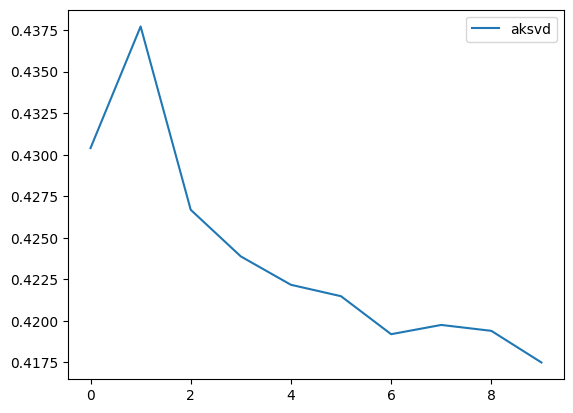

In [3]:
n_components = 16
n_nonzero_coefs = 8 

max_iter = 10
fit_algorithm = "aksvd"
transform_algorithm = "omp"

data = folder_to_tensor("frames/i")
print(data.shape)

dl = DictionaryLearning(
    n_components=n_components,
    max_iter=max_iter,
    fit_algorithm=fit_algorithm,
    transform_algorithm=transform_algorithm,
    n_nonzero_coefs=n_nonzero_coefs,
    code_init=None,
    # dict_init=None,
    dict_init=initialize_dct_basis(num_basis=n_components, basis_length=256),
    verbose=False,
    random_state=None,
    kernel_function=None,
    params=None,
    data_sklearn_compat=True
)

dl.fit(data)

plt.plot(range(max_iter), dl.error_, label=fit_algorithm)
plt.legend()
plt.show()

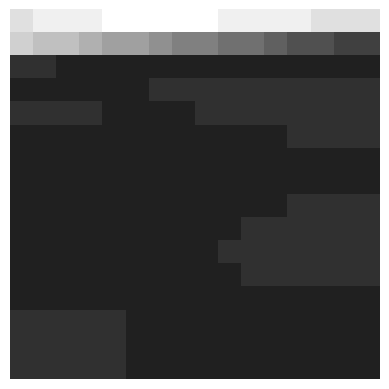

<class 'numpy.ndarray'>
(1, 16) (16, 256)


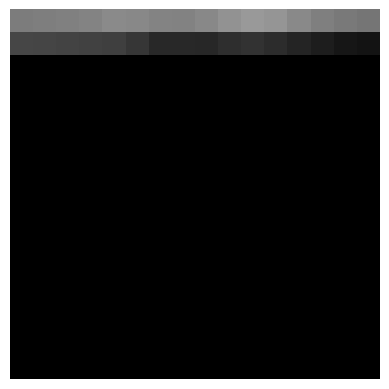

In [6]:
test = data[3]
show_vec(test, (16, 16))
rep = vec2rep(test, dl.D_, n_nonzero_coefs).reshape((1, n_components))
print(type(dl.D_))
print(rep.shape, dl.D_.shape)
new_test = (rep @ dl.D_).reshape((256,))
show_vec(new_test, (16,16))